Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [47]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
import seaborn as sns
import Augmentor
from glob import glob
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,BatchNormalization
import pickle
import sys
import platform


In [32]:
# Print the version of Python
print("Python version: ", sys.version)

# Print the version of TensorFlow
print("TensorFlow version: ", tf.__version__)

# Print the system information
print("System information: ")
print(platform.system())
print(platform.release())
print(platform.architecture())

Python version:  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
TensorFlow version:  2.16.1
System information: 
Windows
10
('64bit', 'WindowsPE')


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [33]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
# Defining the path for train and test images from the local system.
data_dir_train = pathlib.Path("C:\\Users\\hp\Downloads\\Python\\NN\\SkinCancer_ISIC_Dataset\\Train")
data_dir_test  = pathlib.Path("C:\\Users\\hp\\Downloads\\Python\\NN\\SkinCancer_ISIC_Dataset\\Test")

In [35]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [36]:
###The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of 
#shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor 
#of the shape `(32,)`, these are corresponding labels to the 32 images.

In [37]:
batch_size = 32
img_height = 180
img_width = 180

In [38]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Found 2239 files belonging to 9 classes.


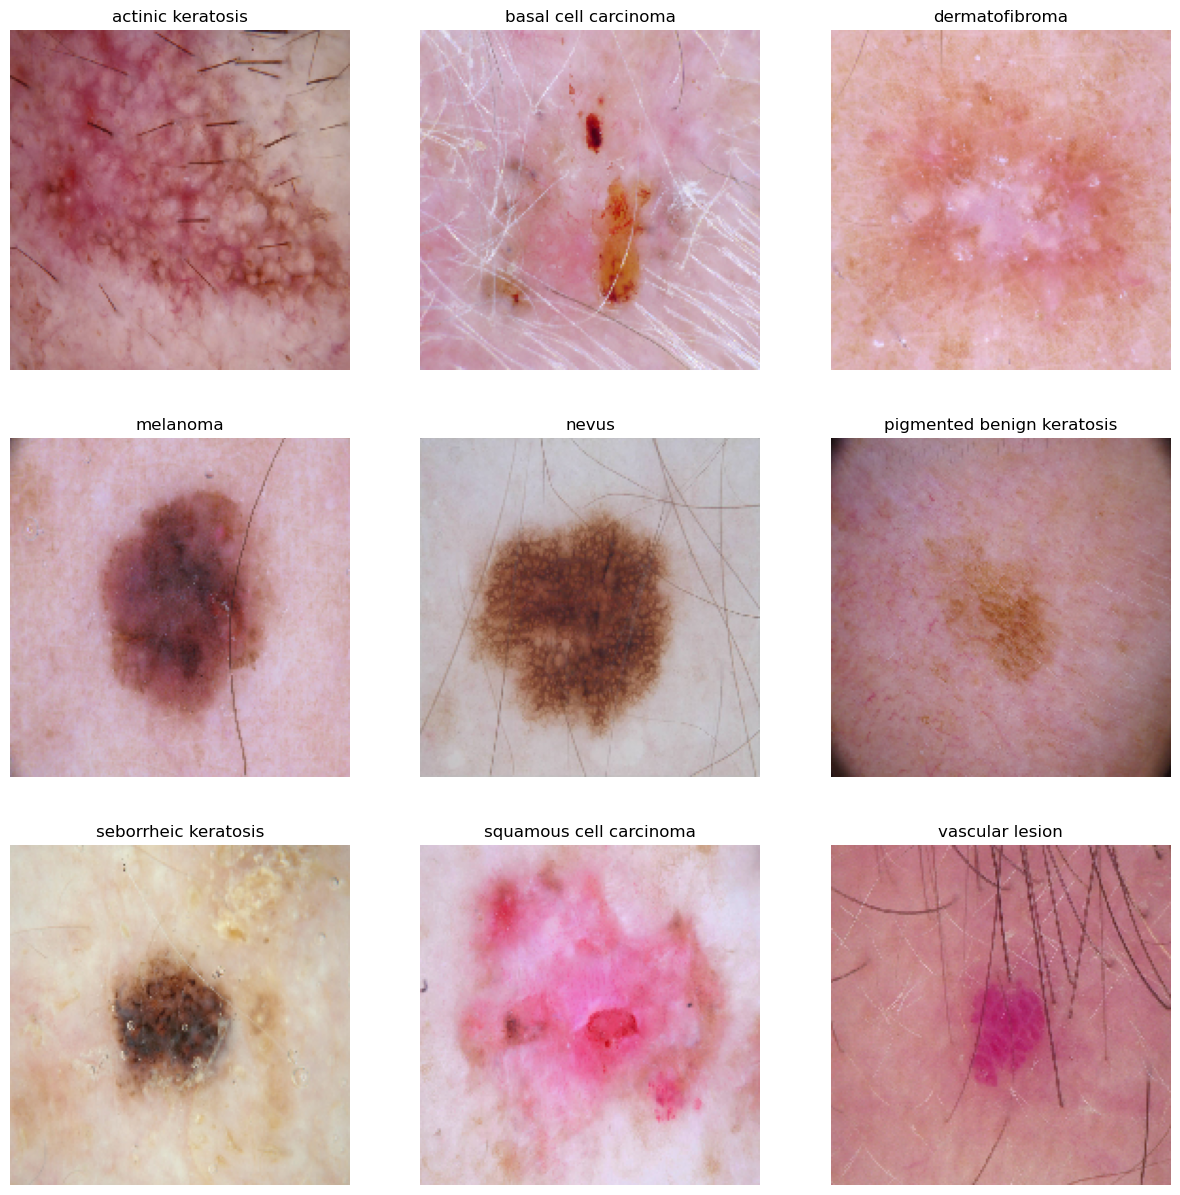

In [39]:
#Visualize one instance of all the class present in the dataset.
from tensorflow.keras.preprocessing.image import load_img
#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [40]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

Class  No. of Image
0           actinic keratosis           114
1        basal cell carcinoma           376
2              dermatofibroma            95
3                    melanoma           438
4                       nevus           357
5  pigmented benign keratosis           462
6        seborrheic keratosis            77
7     squamous cell carcinoma           181
8             vascular lesion           139

<Axes: xlabel='No. of Image', ylabel='Class'>

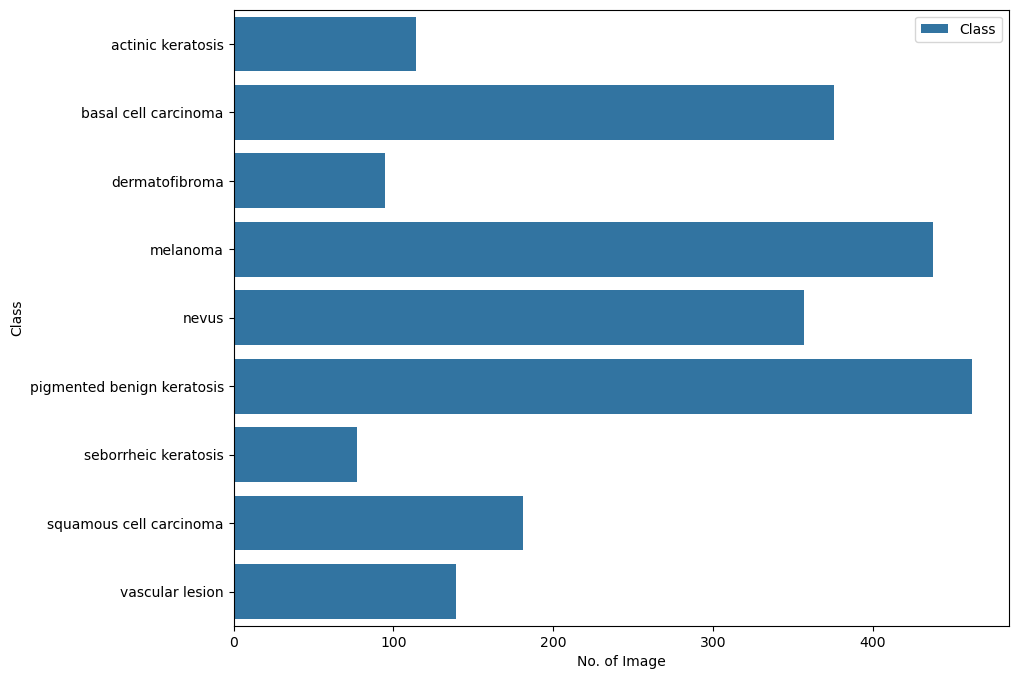

In [41]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [13]:
#install Augmentor
!pip install Augmentor

In [42]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

0


### Create a dataset

Define some parameters for the loader:

Use 80% of the images for training, and 20% for validation.

In [65]:
# train dataset 
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

#train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
##                                                               image_size=(180,180), label_mode='categorical',
#                                                               seed=123,subset="training",
 #                                                              validation_split=0.2)
# Training dataset
# Create a training dataset by loading images from the specified directory using TensorFlow's image_dataset_from_directory function
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [66]:

## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# validation dataset 
#val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
#                                                            image_size=(180,180), label_mode='categorical',
#                                                            seed=123,subset="validation",
#                                                            validation_split=0.2)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [67]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [68]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Cache the training dataset, shuffle it with a buffer size of 1000, and prefetch elements using the AUTOTUNE buffer size
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Cache the validation dataset and prefetch elements using the AUTOTUNE buffer size
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [69]:
model = Sequential()
# Rescale input data to range [0,1] and define input shape
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
# Add convolutional layers along and applying max pooling to reduce spatial dimensions
model.add(Conv2D(16, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2,2)))
# Flatten the feature maps to feed into fully connected layers
model.add(Flatten())
# Add a fully connected layer with 128 neurons and ReLU activation function
model.add(Dense(128,activation='relu'))
# Add the output layer with 9 neurons (one for each class) and softmax activation function for multi-class classification
model.add(Dense(9,activation='softmax'))


In [13]:
### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  #layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [70]:
# View the summary of all layers
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])
#model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [72]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=32,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step - accuracy: 0.2114 - loss: 2.1873 - val_accuracy: 0.2103 - val_loss: 1.9517
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - accuracy: 0.2876 - loss: 1.8888 - val_accuracy: 0.2573 - val_loss: 1.9275
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.3624 - loss: 1.7717 - val_accuracy: 0.4609 - val_loss: 1.5363
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step - accuracy: 0.4344 - loss: 1.5734 - val_accuracy: 0.4698 - val_loss: 1.6233
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.4911 - loss: 1.4211 - val_accuracy: 0.5213 - val_loss: 1.3962
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 240ms/step - accuracy: 0.5515 - loss: 1.2763 - val_accuracy: 0.5526 - val_loss: 1.3661
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 236ms/step - accuracy: 0.5587 - loss: 1.2725 - val_accuracy: 0.4832 - val_loss: 1.4890
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 234ms/step - accuracy: 0.6152 - loss: 1.1199 - val_accu

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

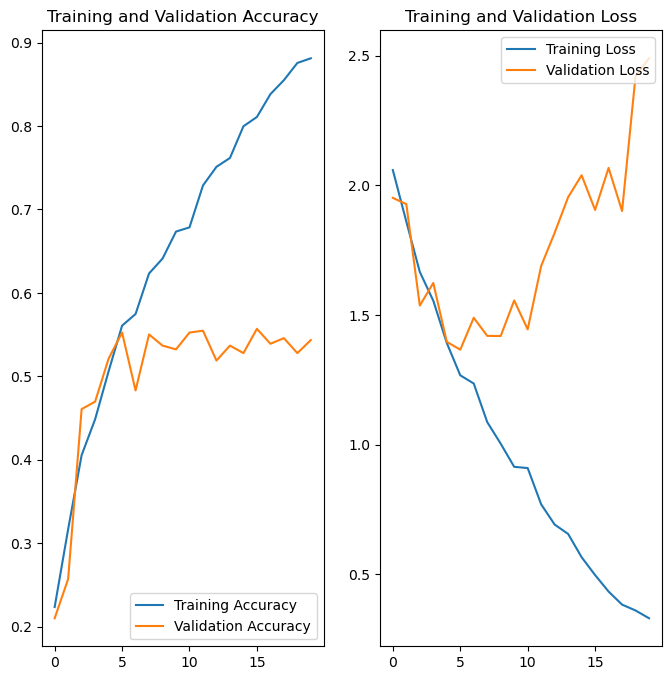

In [73]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
### your code goes here, you can use training or validation data to visualize

In [19]:
### Your code goes here
num_classes = 9

model = Sequential([
  #layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.1567 - loss: 10.9451 - val_accuracy: 0.1499 - val_loss: 13.1958
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.1747 - loss: 13.1093 - val_accuracy: 0.1499 - val_loss: 13.1958
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.1662 - loss: 12.9232 - val_accuracy: 0.1499 - val_loss: 13.1958
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.1723 - loss: 13.1256 - val_accuracy: 0.1499 - val_loss: 13.1958
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.1704 - loss: 13.0728 - val_accuracy: 0.1499 - val_loss: 13.1958
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.1660 - loss: 13.0630 - val_accuracy: 0.1499 - val_loss: 13.1958
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.1561 - loss: 13.1633 - val_accuracy: 0.1499 - val_loss: 13.1958
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.1840 - loss: 13.1848 - val_accuracy: 0.1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [ ]:
###TensorFlow's tf.data API to load and preprocess the training and validation datasets
#for a machine learning model.
# TensorFlow to automatically tune the buffer size used for prefetching data during training
# This transformation caches the dataset in memory after the first epoch, 
#which can speed up subsequent training iterations by avoiding the overhead of loading the data 
#from disk or generating it on the fly.
###  The argument 1000 specifies the size of the shuffle buffer. In this case, the buffer will hold up to 1000 
#samples at a time

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [74]:


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [75]:
### create a keras.Sequential model that applies a series of data augmentation transformations to 
#the input images. 

In [76]:
#data_augmentation = keras.Sequential(
#  [
#    layers.RandomFlip("horizontal",
#                      input_shape=(img_height, img_width, 3)),
#    layers.RandomRotation(0.1),
#    layers.RandomZoom(0.1),
#    layers.RandomTranslation(1, 0.5, fill_mode="reflect", interpolation="bilinear", seed=None, fill_value=0.0),
#    layers.RandomCrop(img_height, img_width),
#  ]
#)
# Data augmentation pipeline using Sequential model
data_augmentation = keras.Sequential([
    # Randomly flip the input images horizontally
    layers.RandomFlip("horizontal"),
    # Randomly rotate the input images by a maximum of 0.1 radians
    layers.RandomRotation(0.1),
    # Randomly zoom into the input images by a maximum of 10%
    layers.RandomZoom(0.1),
    # Randomly adjust the brightness of the input images by a maximum of 0.1
    layers.RandomContrast(0.1)
])

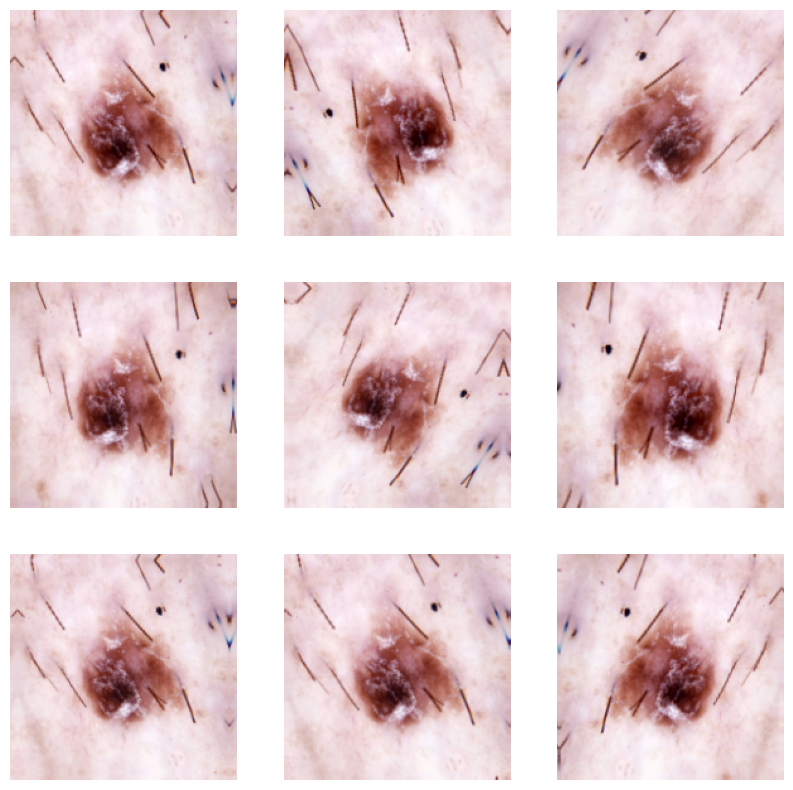

In [77]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [78]:

## Model 2: Define a CNN model with data augmentation

# Initialize the Sequential model
model = Sequential()

# Rescale input data to range [0,1] and define input shape
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# Apply data augmentation to increase dataset diversity and reduce overfitting
model.add(data_augmentation)
# Add convolutional layers along and applying max pooling to reduce spatial dimensions and dropout regularization to prevent overfitting
model.add(Conv2D(32, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Flatten the feature maps to feed into fully connected layers
model.add(Flatten())
# Add a fully connected layer with 128 neurons and ReLU activation function
model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
# Add the output layer with 9 neurons (one for each class) and softmax activation function for multi-class classification
model.add(Dense(9, activation='softmax'))


In [79]:
## compile the model with without Dropout and softmax layer
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [80]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 721ms/step - accuracy: 0.1819 - loss: 3.4070 - val_accuracy: 0.2148 - val_loss: 2.0509
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 723ms/step - accuracy: 0.1838 - loss: 2.0707 - val_accuracy: 0.1924 - val_loss: 2.0624
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 736ms/step - accuracy: 0.2166 - loss: 2.0390 - val_accuracy: 0.1924 - val_loss: 2.0232
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 722ms/step - accuracy: 0.2170 - loss: 2.0057 - val_accuracy: 0.2013 - val_loss: 2.0432
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 719ms/step - accuracy: 0.2347 - loss: 1.9839 - val_accuracy: 0.2998 - val_loss: 1.9040
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 725ms/step - accuracy: 0.3052 - loss: 1.8408 - val_accuracy: 0.4139 - val_loss: 1.6942
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 744ms/step - accuracy: 0.3870 - loss: 1.7109 - val_accuracy: 0.4340 - val_loss: 1.6747
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 715ms/step - accuracy: 0.3946 - loss: 1.6902 - val_accu

In [ ]:
##Accuracy is very very low hence skiped the execution.

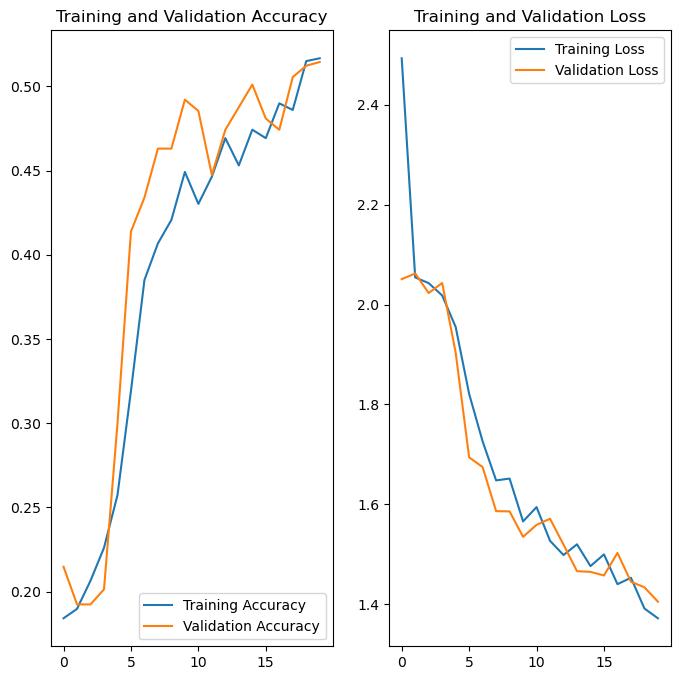

In [84]:
import matplotlib.pyplot as plt
epochs=20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
## Class Distribution
#We will now examine the class distribution in training dataset

In [85]:
### Counting the number of images in each class
# Create an empty list to store dictionaries
class_diff_data = []

# Iterate through each class name
for name in class_names:
    number = len(list(data_dir_train.glob(f'{name}/*.jpg')))  # Count the number of images in the class
    # Append the class name and the number of images as a dictionary to the list
    class_diff_data.append({'class': name, 'number': number})

# Create a DataFrame from the list of dictionaries
class_diff = pd.DataFrame(class_diff_data)

# Display the DataFrame containing class names and the number of images in each class
class_diff

class  number
0           actinic keratosis     114
1        basal cell carcinoma     376
2              dermatofibroma      95
3                    melanoma     438
4                       nevus     357
5  pigmented benign keratosis     462
6        seborrheic keratosis      77
7     squamous cell carcinoma     181
8             vascular lesion     139

<function matplotlib.pyplot.show(close=None, block=None)>

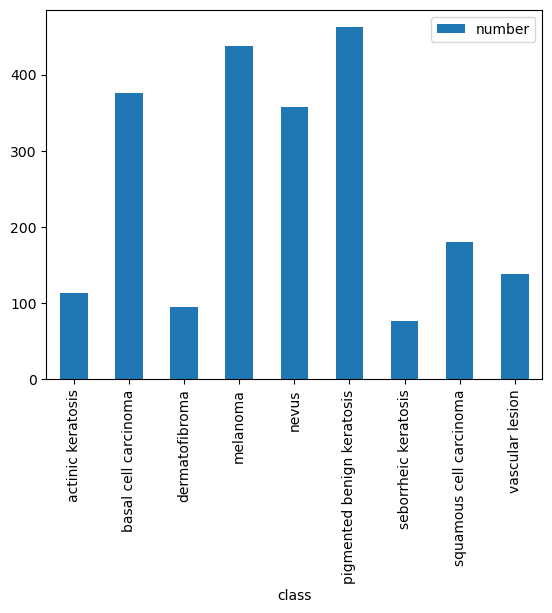

In [86]:
## Bar plots of the class distribution
class_diff.plot.bar(x='class',y='number',rot=90)
plt.show

In [ ]:
## Handling Class imbalances

In [87]:

# Get the all path list for the images
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

len(path_list)

2239

In [88]:
# Get the original DF from the train folder
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

Path              Label
0     C:\Users\hp\Downloads\Python\NN\SkinCancer_ISI...  actinic keratosis
1     C:\Users\hp\Downloads\Python\NN\SkinCancer_ISI...  actinic keratosis
2     C:\Users\hp\Downloads\Python\NN\SkinCancer_ISI...  actinic keratosis
3     C:\Users\hp\Downloads\Python\NN\SkinCancer_ISI...  actinic keratosis
4     C:\Users\hp\Downloads\Python\NN\SkinCancer_ISI...  actinic keratosis
...                                                 ...                ...
2234  C:\Users\hp\Downloads\Python\NN\SkinCancer_ISI...    vascular lesion
2235  C:\Users\hp\Downloads\Python\NN\SkinCancer_ISI...    vascular lesion
2236  C:\Users\hp\Downloads\Python\NN\SkinCancer_ISI...    vascular lesion
2237  C:\Users\hp\Downloads\Python\NN\SkinCancer_ISI...    vascular lesion
2238  C:\Users\hp\Downloads\Python\NN\SkinCancer_ISI...    vascular lesion

[2239 rows x 2 columns]

In [89]:
original_df['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

In [72]:
### Get Class distribution

Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


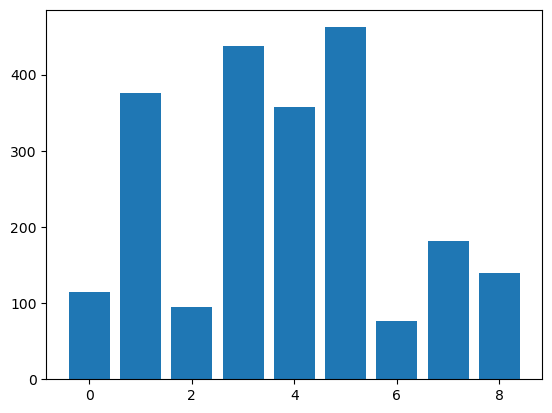

In [33]:

from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
## To use `Augmentor`, the following general procedure is followed:

## 1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
## 2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
## 3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [90]:
# GET image count
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

0


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.
Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.
So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [91]:
# Iterate through each class
import Augmentor
path_to_training_dataset=data_dir_train

for class_name in class_names:
    p = Augmentor.Pipeline((path_to_training_dataset / class_name).as_posix())
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to C:/Users/hp/Downloads/Python/NN/SkinCancer_ISIC_Dataset/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22F8DED0D10>: 100%|██████████| 500/500 [00:03<00:00, 139.62 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to C:/Users/hp/Downloads/Python/NN/SkinCancer_ISIC_Dataset/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22FD00C8B90>: 100%|██████████| 500/500 [00:03<00:00, 139.71 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:/Users/hp/Downloads/Python/NN/SkinCancer_ISIC_Dataset/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x22F8DEC5150>: 100%|██████████| 500/500 [00:03<00:00, 140.70 Samples/s]


Initialised with 438 image(s) found.
Output directory set to C:/Users/hp/Downloads/Python/NN/SkinCancer_ISIC_Dataset/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x22F9120D0D0>: 100%|██████████| 500/500 [00:18<00:00, 26.94 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to C:/Users/hp/Downloads/Python/NN/SkinCancer_ISIC_Dataset/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x22F8CD91B50>: 100%|██████████| 500/500 [00:14<00:00, 33.44 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to C:/Users/hp/Downloads/Python/NN/SkinCancer_ISIC_Dataset/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22FCBA5B3D0>: 100%|██████████| 500/500 [00:03<00:00, 143.39 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to C:/Users/hp/Downloads/Python/NN/SkinCancer_ISIC_Dataset/Train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x22FCB2A2590>: 100%|██████████| 500/500 [00:08<00:00, 61.68 Samples/s]


Initialised with 181 image(s) found.
Output directory set to C:/Users/hp/Downloads/Python/NN/SkinCancer_ISIC_Dataset/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x22F8CE4ACD0>: 100%|██████████| 500/500 [00:03<00:00, 135.36 Samples/s]


Initialised with 139 image(s) found.
Output directory set to C:/Users/hp/Downloads/Python/NN/SkinCancer_ISIC_Dataset/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22F8DF2BAD0>: 100%|██████████| 500/500 [00:03<00:00, 140.66 Samples/s]                  


In [70]:
### Lets see the distribution of augmented data after adding new images to the original training data.

In [92]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list_new , lesion_list_new

In [94]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [95]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['C:\\Users\\hp\\Downloads\\Python\\NN\\SkinCancer_ISIC_Dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_632c0d85-b983-4d37-8eed-4b5daeb0a3fb.jpg',
 'C:\\Users\\hp\\Downloads\\Python\\NN\\SkinCancer_ISIC_Dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6b6bc946-7ba6-4971-9d60-d44d2643a95c.jpg',
 'C:\\Users\\hp\\Downloads\\Python\\NN\\SkinCancer_ISIC_Dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_eb2aedd7-a7c0-4cf6-88da-7cb0de3b67c6.jpg',
 'C:\\Users\\hp\\Downloads\\Python\\NN\\SkinCancer_ISIC_Dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_f8cb1dfa-a098-4d12-8c20-0418de445ba7.jpg',
 'C:\\Users\\hp\\Downloads\\Python\\NN\\SkinCancer_ISIC_Dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_1dab1a5d-9c18-4c6e-ba83-0876eb702b46.jpg',
 'C:\\Users\\hp\\Downloads\\Python\\NN\\SkinCancer_ISIC_Dataset\\Train

In [96]:
## Creating a list containing all the labels of the diseases for the newly generated images
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [97]:
# get dataset with new columns appended in the dataframe/
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df = pd.concat([original_df, df2], ignore_index=True)

In [98]:
# View the  class count of each folders
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

In [99]:
# set batch size and image size.
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
## Final Model building & training
#On the dataset after class imbalances have been resolved

In [113]:
## Training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [114]:
#Get the validation dataset from the train datset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [115]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [111]:
train_ds.shape

AttributeError: '_PrefetchDataset' object has no attribute 'shape'

In [116]:
### Final Model
model = Sequential()

# Rescaling the 1st layer
model.add(layers.Rescaling(1./255,input_shape=(img_height, img_width,3)))
# Add convolutional layers along and applying max pooling to reduce spatial dimensions and dropout regularization to prevent overfitting
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
# Flatten the feature maps to feed into fully connected layers
model.add(layers.Flatten())
# Add a fully connected layers with 256, 128 and 64 neurons and ReLU activation function
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
# Add the output layer with 9 neurons (one for each class) and softmax activation function for multi-class classification
model.add(layers.Dense(9,activation='softmax'))




In [117]:
## Compile the Model, for early stop and cache we can use below commented code.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
"""
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

#model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("my_model1.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])
"""


In [118]:
# View the summary of all layers
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 10, 10, 256)    │     3,965,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,738,825 (21.89 MB)

 Trainable params: 5,738,825 (21.89 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:

## Training the final model for 30 epochs
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.1479 - loss: 2.1750 - val_accuracy: 0.2940 - val_loss: 1.7903
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.2868 - loss: 1.8360 - val_accuracy: 0.4388 - val_loss: 1.5703
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.3514 - loss: 1.6325 - val_accuracy: 0.4499 - val_loss: 1.4104
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.4099 - loss: 1.5474 - val_accuracy: 0.4410 - val_loss: 1.3583
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.4240 - loss: 1.4588 - val_accuracy: 0.5108 - val_loss: 1.2855
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.4489 - loss: 1.4076 - val_accuracy: 0.5011 - val_loss: 1.2529
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.4543 - loss: 1.3944 - val_accuracy: 0.5048 - val_loss: 1.2816
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.4901 - loss: 1.3322 - val_accu

In [ ]:
# VIsuallize the model accuracy result


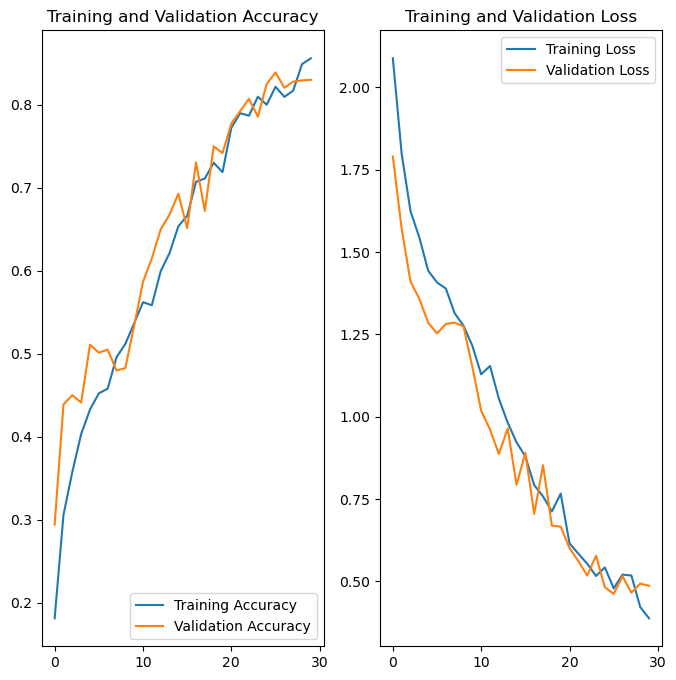

In [121]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [127]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 10, 10, 256)    │     3,965,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,216,477 (65.68 MB)

 Trainable params: 5,738,825 (21.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,477,652 (43.78 MB)

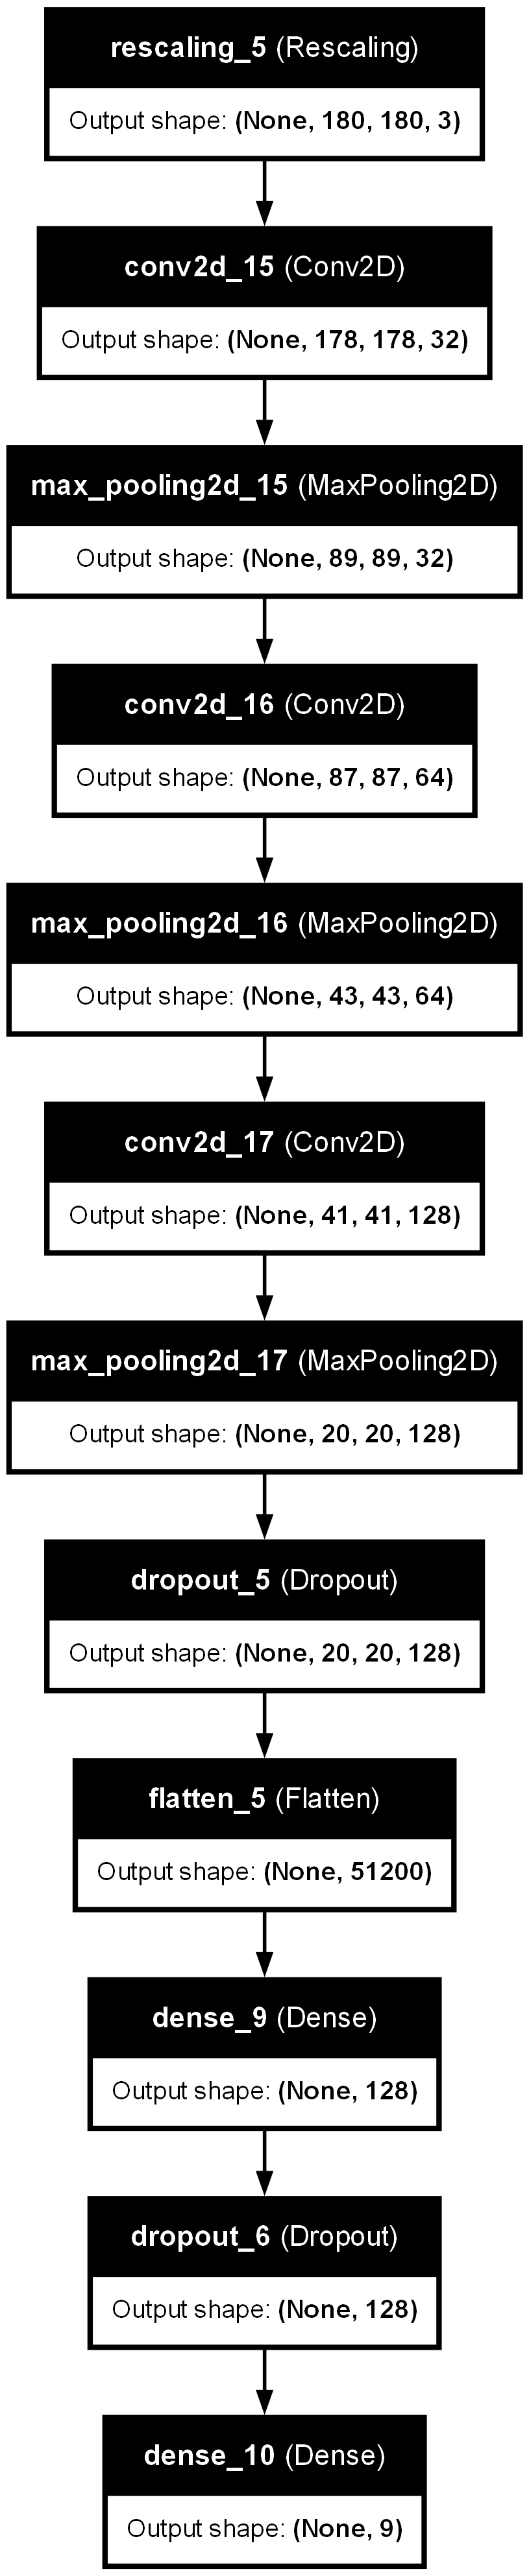

In [60]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Compile the model ans set the Checkpoints and run with 20 epochs

In [ ]:
### Visualizing training results

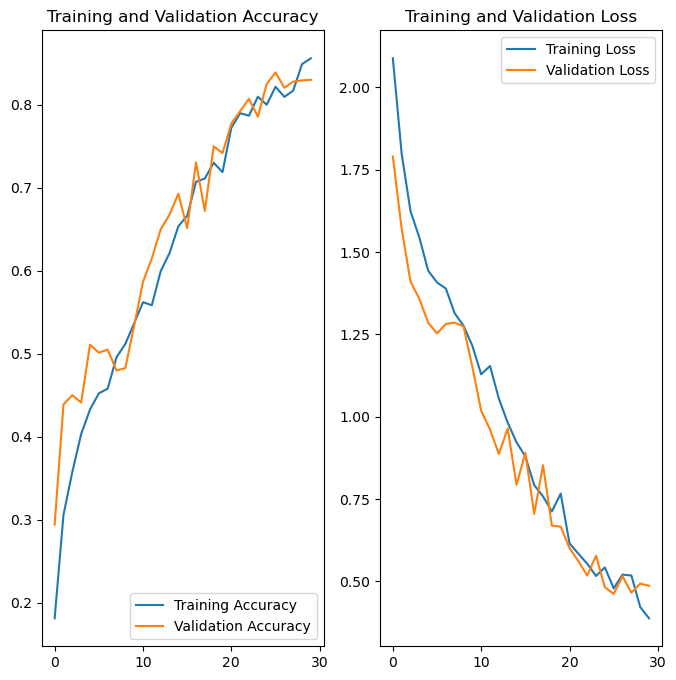

In [122]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = np.arange(len(acc))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
#['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 
#'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 
#'vascular lesion']

In [1]:
#7th number class has lowest samples
#From the above array  "seborrheic keratosis" has the lowest samples.
#Class=6, n=77 (3.439%)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
The model has improved from scenarios are, 1. without tuning like dropouts 2. Data_augmentation 3. Augumentor library
the accritacu has improved from 

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
#['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
# 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis'
#, 'squamous cell carcinoma', 'vascular lesion']## Your code goes here.

In [ ]:
Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


In [ ]:
Which class has the least number of samples?
Class=6, n=77 (3.439%)

- Which classes dominate the data in terms proportionate number of samples?
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=1, n=376 (16.793%)
total clases dominated by class 4,5,6,2 is 72.93% 

#### **Todo:**  Visualize the model results

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
The score was very low when the layers used are with out Dropouts and Augmentor.
As they are included the accuracy of train dataset and validation dataset improved significantly.

Epoch 20: val_accuracy improved from 0.81189 to 0.84615, saving model to my_model1.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 98s 547ms/step - accuracy: 0.8630 - loss: 0.3811 - val_accuracy: 0.8462 - val_loss: 0.5555
                

In [123]:
import pickle

#model.save('full_model41.h5')
model.save('my_modelF.keras')
    
# Load entire model
loaded_model = tf.keras.models.load_model('my_modelF.keras')

# Save training history
with open('training_historyF.pickle', 'wb') as file:
    pickle.dump(history.history, file)

# Load training history
with open('training_historyF.pickle', 'rb') as file:
    loaded_history = pickle.load(file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


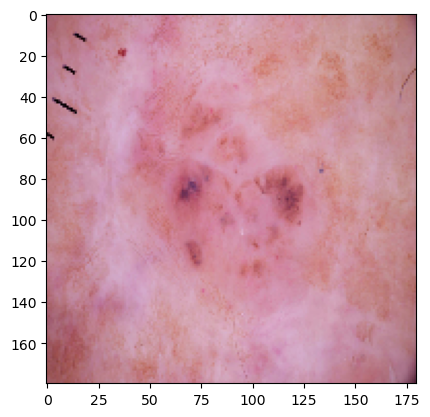

In [131]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img


Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)
img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

In [ ]:
## END OF Assignment ##

In [77]:
import sys
import tensorflow as tf
import platform

# Print the version of Python
print("Python version: ", sys.version)

# Print the version of TensorFlow
print("TensorFlow version: ", tf.__version__)

# Print the system information
print("System information: ")
print(platform.system())
print(platform.release())
print(platform.architecture())

Python version:  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
TensorFlow version:  2.16.1
System information: 
Windows
10
('64bit', 'WindowsPE')


In [17]:
import pickle

#model.save('full_model41.h5')
#model.save('my_model30.keras')
    
# Load entire model
model = tf.keras.models.load_model('my_model30.keras')

# Save training history
#with open('training_history30.pickle', 'wb') as file:
#    pickle.dump(history.history, file)

# Load training history
with open('training_history30.pickle', 'rb') as file:
    #loaded_history = pickle.load(file)    
    history = pickle.load(file)

In [ ]:
## END of 30 epoch run ##